In [135]:
# !pip3 install "dask[complete]"
# !pip3 install plotly

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib
import matplotlib.dates as mdates
import sklearn
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [136]:
train_df = pd.read_csv("MLFinalProjectDataset/train_data.csv")
# train_df['timestamp'] = pd.to_datetime(train_df.timestamp)
train_df.head(5)

,displayId,timestamp,dayOfWeek,hourOfDay,advertiserId,campaignId,creativeId,publisher,widgetId,device,os,browser,source,docId,userId,clicked
0,4706262,1578429005696,4,0,290,7855,6,10,6262,0,0,0,11,3543873,2688642,1
1,4706262,1578429005696,4,0,1386,7967,15,10,6262,0,0,0,11,3543873,2688642,0
2,4706262,1578429005696,4,0,378,1160,3610,10,6262,0,0,0,11,3543873,2688642,0
3,4706267,1578429007726,4,0,6642,804,3475,14,607,1,3,0,15,6245475,2688641,1
4,4706267,1578429007726,4,0,8414,6155,5271,14,607,1,3,0,15,6245475,2688641,0


<div>
    <h1>Feature selection </h1>
    </div>
    

<p></p>

<div dir="rtl">
    به منظور کاهش فضای ویژگی برای اینکه سایز داده‌ها قابل کنترل باشد و همچنین برای کاهش overfitting، از
   grid-search cross-validation روی
    logistic regression with L1 normalization
    برای به دست آوردن tradeoff
    بین تعداد فیچرها و F1-score
    استفاده می‌کنیم.
    با توجه به اینکه مجوعه داده ما نامتوازن است، معیار F1
    عملکرد بهتری نسبت به معیارهای مرسوم دارد. زیرا معادل میانگین هارمونیک بین 
    precision و recall است.
     با استفاده از نرم L1 
    در دسته‌بند logistic regression
    مدل می‌توانند وزن مجموعه مشخصی از فیچرها را 0 قرار دهد. که نشان‌دهنده‌ی این است که این ویژگی‌ها در دسته‌بندی تاثیری ندارند.
    به علاوه می‌توانیم مقدار پارامتر ورودی class_weight
    را در دسته‌بند balanced 
    قرار ددهیم در این صورت دسته‌بند وزن هر داده را متناسب با نسبت لیبل تارگت آن قرار می‌دهد (نمونه‌های که برچسب clicked آن‌ها ۱ است وزن بیشتری دارند).

</div>

In [137]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import LinearSVC

In [138]:
features_mask = ['displayId', 'timestamp', 'dayOfWeek', 'hourOfDay', 'advertiserId',
       'campaignId', 'creativeId', 'publisher', 'widgetId', 'device', 'os',
       'browser', 'source', 'docId', 'userId']
target_mask = 'clicked'

train_sample_df = train_df[features_mask + [target_mask]].sample(frac=0.01, random_state=42)

# normalize
x = train_sample_df.values
max_abs_scaler = preprocessing.MaxAbsScaler()
X_train_maxabs  = max_abs_scaler.fit_transform(x)
train_sample_df = pd.DataFrame(X_train_maxabs, columns=train_sample_df.columns)


In [139]:
def one_hot_obj_features(df, features):
    new_df = pd.get_dummies(df, columns=features, sparse=True)
    return new_df


features_mask = np.array(train_sample_df.columns[train_sample_df.columns != target_mask].tolist())


X_train, X_test, y_train, y_test = train_test_split(
    train_sample_df[features_mask].values, 
    train_sample_df[target_mask].values,
    stratify=train_sample_df[target_mask],
    test_size=0.3,
    random_state=42
)

In [89]:
n_splits = 3
c_values = np.logspace(-3, 0, 7) # the parameter C controls the sparsity: the smaller C the fewer features selected.
skf_cv = StratifiedKFold(n_splits=n_splits)
scores = np.zeros(7)
nr_params = np.zeros(7)

for train_idx, valid_idx in skf_cv.split(X_train, y_train):
    for i, c in enumerate(c_values):
        # Fit the logistic regression model to the data
        lr_clf = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=c)
        lr_clf.fit(X_train[train_idx], y_train[train_idx])
        
        # Evaluate on validation set
        y_pred = lr_clf.predict(X_train[valid_idx])
        f1 = f1_score(y_train[valid_idx], y_pred, average='weighted')
        scores[i] += f1 / n_splits
        
        # Find which parameters were selected
        select_model = SelectFromModel(lr_clf, prefit=True)
        nr_params[i] += np.sum(select_model.get_support()) / n_splits

In [90]:
scores

array([0.68443419, 0.68443419, 0.68443419, 0.51140534, 0.52977722,
       0.53645322, 0.53996598])

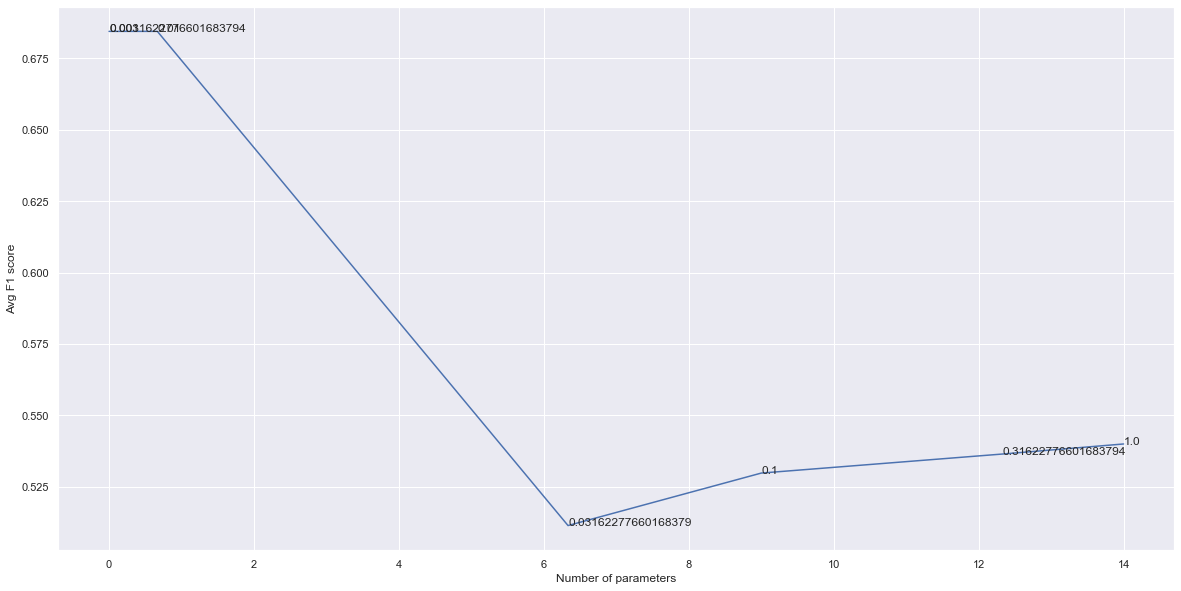

In [145]:
plt.figure(figsize=(20,10))
plt.plot(nr_params, scores)
for i, c in enumerate(c_values):
    plt.annotate(c, (nr_params[i], scores[i]))
plt.xlabel("Number of parameters")
plt.ylabel("Avg F1 score")
plt.show();



<div dir="rtl">
    به نظر می رسد پارامترهای بدست آمده با استفاده از
    c = 0.01
    قادر به کاهش ابعاد پارامترها است و در عین حال قدرت 
    generalization 
    مدل را نیز بهبود می‌بخشند.
    </div>
<div dir="rtl">  
        مدل را با این پارامتر ترین می‌کنیم تا ویژگی‌ها انتخاب شده را به دست آوریم.

</div>

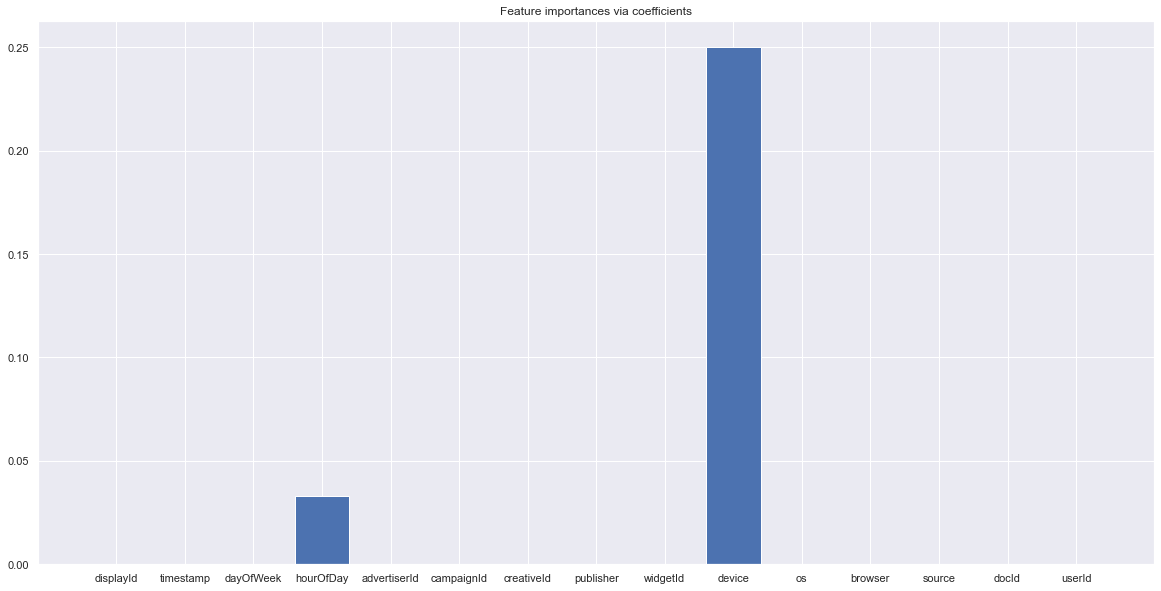

In [92]:
lr_clf = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=0.01)
lr_clf.fit(X_train, y_train)

select_model = SelectFromModel(lr_clf, prefit=True)
pruned_params = select_model.get_support()

importance = np.abs(lr_clf.coef_[0])
features_mask = np.array(train_sample_df.columns[train_sample_df.columns != target_mask].tolist())
plt.figure(figsize=(20,10))
plt.bar(height=importance, x=features_mask)
plt.title("Feature importances via coefficients")
plt.show()


<div dir="rtl">
    با استفاده از روش بالا دو ویژگی 
    <b> device, hourOfDay </b>
    ویژگی‌های مهمی برای دسته‌بندی هستند (با توجه به نمودار اهمیت ویژگی device
    بیشتر است). که 
    <b>
    همان نتیجه‌ای است که با استفاده از EDA
    نیز به آن رسیده بودیم.
    </b>
    </div>
    <p> </p>
    <div dir="rtl">
    برای انتخاب ویژگی‌های بیشتر از مدل‌های دیگر استفاده می‌کنیم.
    </div>

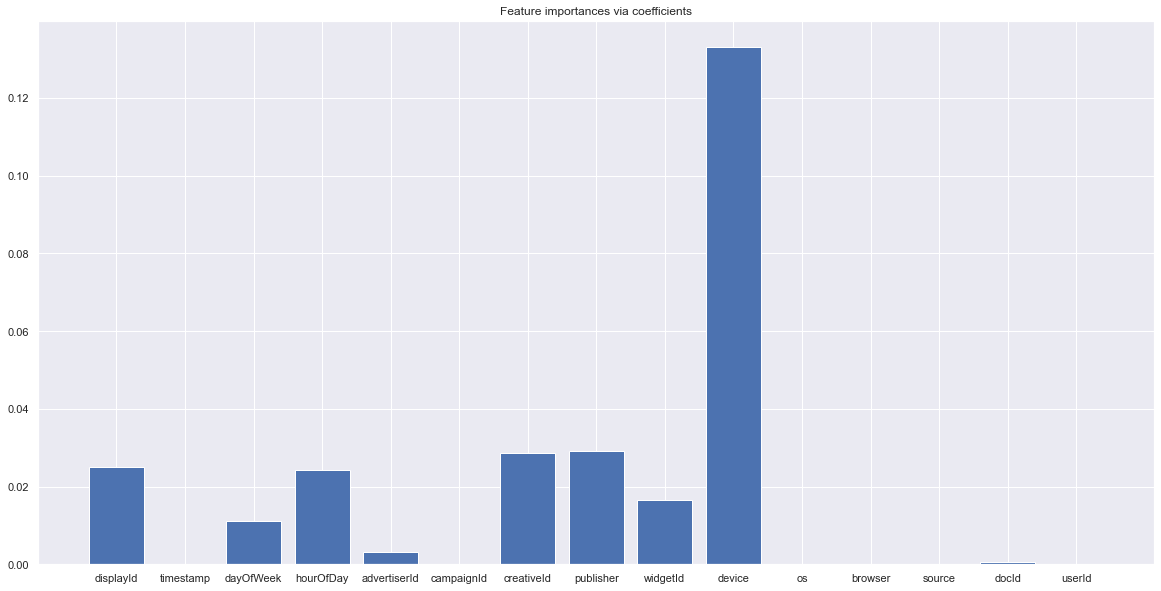

In [142]:
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X_train, y_train)
importance = np.abs(lasso.coef_)
features_mask = np.array(train_sample_df.columns[train_sample_df.columns != target_mask].tolist())
plt.figure(figsize=(20,10))
plt.bar(height=importance, x=features_mask)
plt.title("Feature importances via coefficients")
plt.show()

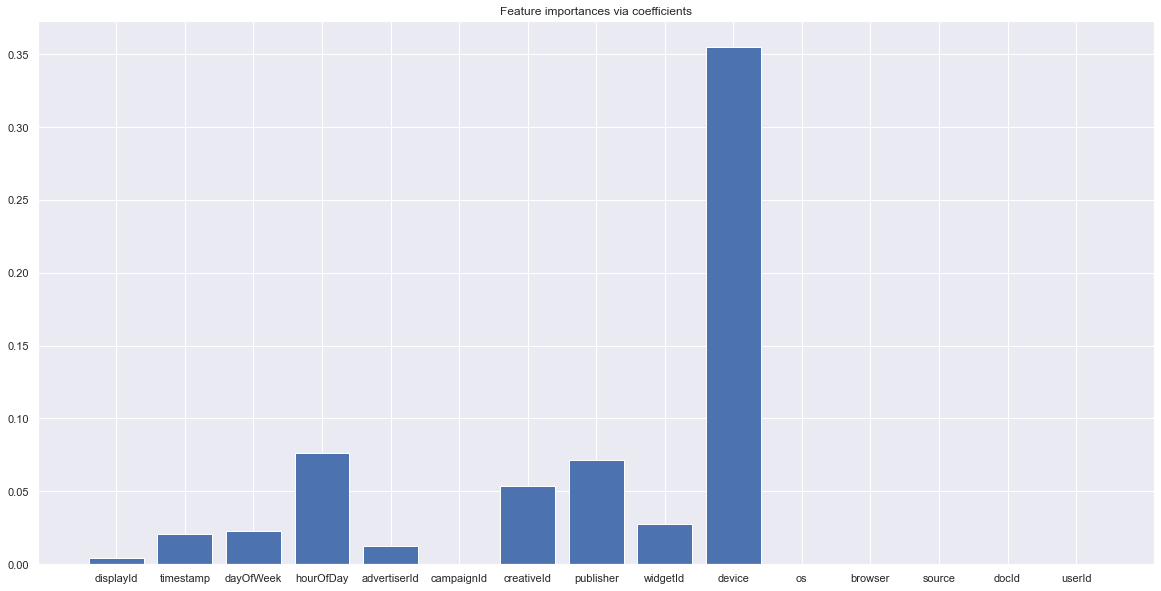

In [143]:
from sklearn.svm import LinearSVC


lsvc = LinearSVC(C=0.01, class_weight='balanced', penalty="l1", dual=False, max_iter=100000).fit(X_train, y_train)
importance = np.abs(lsvc.coef_[0])
features_mask = np.array(train_sample_df.columns[train_sample_df.columns != target_mask].tolist())
plt.figure(figsize=(20,10))
plt.bar(height=importance, x=features_mask)
plt.title("Feature importances via coefficients")
plt.show()

In [140]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(min_samples_split=20, random_state=0, min_samples_leaf=2, max_depth=3, class_weight='balanced')
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=2,
                       min_samples_split=20, random_state=0)

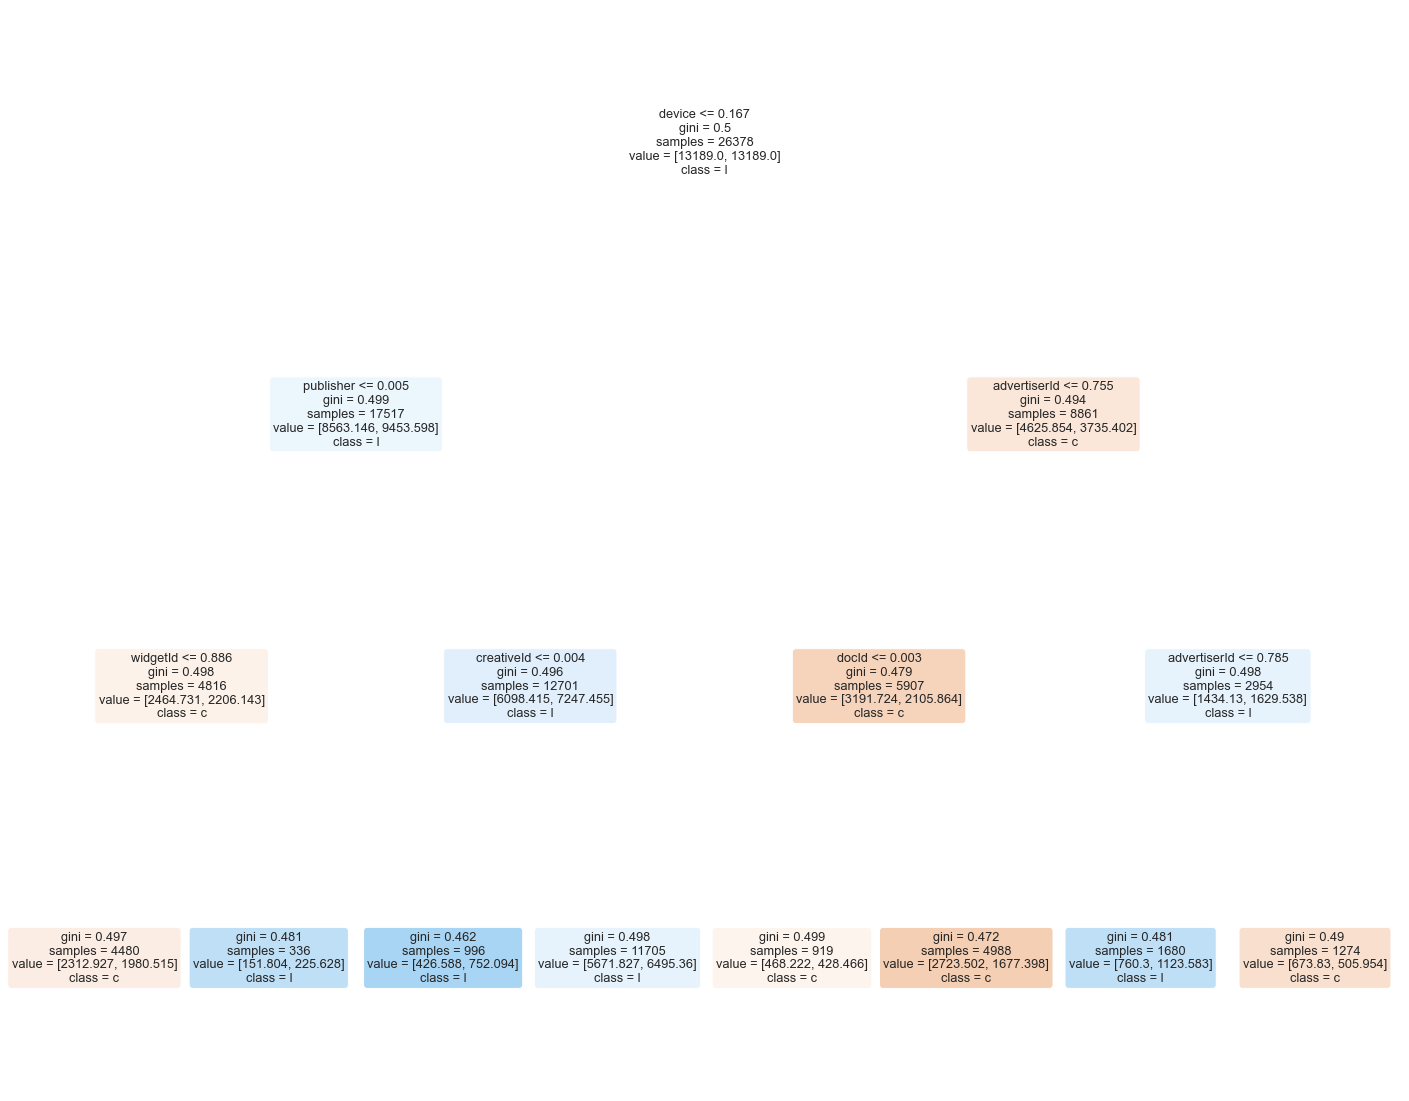

In [144]:
from sklearn import tree
# ! pip3 install pydot
import pydot as pydot

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_clf, 
                   feature_names=features_mask,  
                   class_names=target_mask,
                   filled=True,
                   rounded=True)
fig.savefig("decistion_tree.png")

<div dir="rtl">
    با اشتراک نتایج بالا می‌توان به این نتیجه رسید که ویژگی‌های زیر اهمیت بیشتری دارند (ویژگی‌ها به ترتیب اهمیت نوشته شدند).
    
</div>
<div>
    <h2>device, hourOfDay, publisher, creativeId, widgetId</h2>
    <h4> + dayOfWeek, advertiserId </h4>
</div>